In [447]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [448]:
#first of all, we should download files and import LinearRegression
from sklearn.linear_model import LinearRegression
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv ("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [449]:
#secondly, we need to prepare our data

##let's make it more convenient
train['SalePriceLog'] =  np.log1p(train['SalePrice'])
train['LotAreaLog'] =  np.log1p(train['LotArea'])
test['LotAreaLog'] =  np.log1p(test['LotArea'])

##normalize our 'YearBuilt' data
_max = max(max(train['YearBuilt']), max(test['YearBuilt']))
_min = min(min(train['YearBuilt']), min(test['YearBuilt']))
train['YearBuilt'] = (train['YearBuilt'] - _min)/(_max - _min)
test['YearBuilt'] = (test['YearBuilt'] - _min)/(_max - _min)

### In class we've used such features as 'LotArea', 'YearBuilt'
### Let's add some new features and build new models

# First model

### I've decided to add such feature as 'OverallCond'. I think that the house in a good condition should be more pricy than in a bad condition.

#### Let's see if there is any correlation between 'OverallCond' and 'SalePrice'.

In [450]:
_max = max(max(train['OverallCond']), max(test['OverallCond']))
_min = min(min(train['OverallCond']), min(test['OverallCond']))
train['OverallCond'] = (train['OverallCond'] - _min)/(_max - _min)
test['OverallCond'] = (test['OverallCond'] - _min)/(_max - _min)

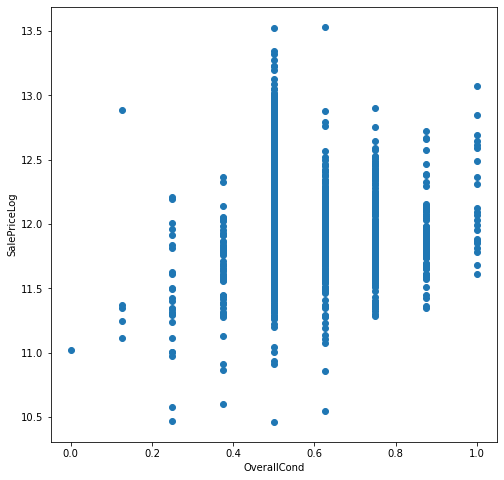

In [451]:
plt.figure(figsize= (8,8))
plt.scatter( train['OverallCond'], train['SalePriceLog'])
plt.xlabel('OverallCond')
plt.ylabel('SalePriceLog')
plt.show()

In [452]:
#first of all, we should make a model
reg = LinearRegression()
reg.fit(train[['LotAreaLog','YearBuilt','OverallCond']],train['SalePriceLog'])

LinearRegression()

In [453]:
#let's print our regression coefficients
print(reg.coef_, reg.intercept_)

[0.29865856 1.20125911 0.61176977] 8.08900321329769


#### This way, we got our first linear regression model
$$ a(x, \textbf{w}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3= 8.089 + 0.299x_1 + 1.201x_2 + 0.612x_3, where$$

$$x_1 is 'LotAreaLog'\\
x_2 is 'YearBuilt'\\
x_3 is 'OverallCond'$$

In [454]:
#now we will use our model to make prediction on test data
prediction = reg.predict(test[['LotAreaLog','YearBuilt','OverallCond']])

In [455]:
#we need to save results of our prediction and submit it
sample_submission['SalePrice']=  np.exp( prediction)-1
sample_submission.to_csv('submission.csv', index = None)

In [456]:
#cross-validation time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

kf = KFold (n_splits = 5)
kf.get_n_splits(train)

print(kf)

rmse_array = []

i= 0   
for i, (train_index, test_index) in enumerate(kf.split(train)):

    X_train, X_test = train.loc[train_index, ['LotAreaLog','YearBuilt','OverallCond']], train.loc[test_index, ['LotAreaLog','YearBuilt','OverallCond']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    print("model.coef_: ",model.coef_ , model.intercept_)
    prediction = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=prediction , y_true=y_test))    
    rmse_array.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_array))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_array))))
mean_rmse_1 = np.mean(rmse_array)

KFold(n_splits=5, random_state=None, shuffle=False)
model.coef_:  [0.29352984 1.21998606 0.63218808] 8.110001600223338
0 0.2608276028897268
model.coef_:  [0.30029281 1.16795076 0.58105792] 8.114865700182772
1 0.2826222961873936
model.coef_:  [0.29106673 1.19355566 0.61004737] 8.16284911638855
2 0.2791031896774726
model.coef_:  [0.30679481 1.1847809  0.60465232] 8.035975941344622
3 0.2598741606277644
model.coef_:  [0.301857   1.24060696 0.6289676 ] 8.019773070068162
4 0.28466190078965314
Mean rmse for 5-fold: 0.2734178300344021
std rmse for 5-fold: 0.010820530847722078


# For our first linear regression model we got next results:

### Kaggle score = 0.28014
### Mean on folds of cross-validation = 0.27342

# Second model

### I've decided to add such feature as 'GarageArea' to the first model. Nowadays, each family has at least one car, so it will be important to have a garage area. Moreover, people can store a lot of unneccessary stuff there,so the area of garage should be quite big. 

#### Let's see if there is any correlation between 'GarageArea' and 'SalePrice'.

In [457]:
#the first thought that comes to mind is to use logarithms, but we have houses with zero garage area. So i've decided just to normalize it.
_max = max(max(train['GarageArea']), max(test['GarageArea']))
_min = min(min(train['GarageArea']), min(test['GarageArea']))
train['GarageArea'] = (train['GarageArea'] - _min)/(_max - _min)
test['GarageArea'] = (test['GarageArea'] - _min)/(_max - _min)

In [458]:
#we have one None in test['GarageArea'],  I will substitute it with zero
test['GarageArea'] = (test['GarageArea']).fillna(0)

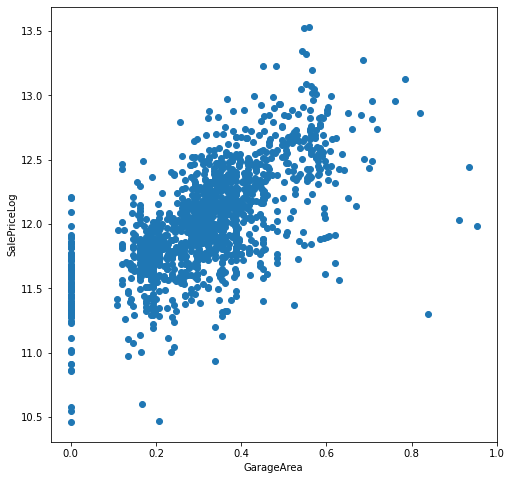

In [459]:
plt.figure(figsize= (8,8))
plt.scatter( train['GarageArea'], train['SalePriceLog'])
plt.xlabel('GarageArea')
plt.ylabel('SalePriceLog')
plt.show()

In [460]:
#let's make a model
reg = LinearRegression()
reg.fit(train[['LotAreaLog','YearBuilt','OverallCond','GarageArea']],train['SalePriceLog'])

LinearRegression()

In [461]:
#let's print our regression coefficients
print(reg.coef_, reg.intercept_)

[0.2116062  0.88141179 0.57794597 1.00585085] 8.811832435687261


#### This way, we got our second linear regression model
$$ a(x, \textbf{w}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4= 8.812 + 0.212x_1 + 0.881x_2 + 0.578x_3 + 1.006x_4, where$$

$$x_1 is 'LotAreaLog'\\
x_2 is 'YearBuilt'\\
x_3 is 'OverallCond'\\
x_4 is 'GarageArea'$$

In [462]:
#now we will use our model to make prediction on test data
prediction = reg.predict(test[['LotAreaLog','YearBuilt','OverallCond','GarageArea']])

In [463]:
#we need to save results of our prediction and submit it
sample_submission['SalePrice']=  np.exp( prediction)-1
sample_submission.to_csv('submission.csv', index = None)

In [464]:
#cross-validation time
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

kf = KFold (n_splits = 5)
kf.get_n_splits(train)

print(kf)

rmse_array = []

i= 0   
for i, (train_index, test_index) in enumerate(kf.split(train)):

    X_train, X_test = train.loc[train_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea']], train.loc[test_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    print("model.coef_: ",model.coef_ , model.intercept_)
    prediction = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=prediction , y_true=y_test))    
    rmse_array.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_array))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_array))))
mean_rmse_2 = np.mean(rmse_array)

KFold(n_splits=5, random_state=None, shuffle=False)
model.coef_:  [0.20826126 0.90648062 0.59639964 0.98322082] 8.81843996797593
0 0.22762202411174434
model.coef_:  [0.21151249 0.87449048 0.56916566 0.96468071] 8.833924046488097
1 0.24896253573688945
model.coef_:  [0.20748938 0.87195155 0.57763994 0.99707641] 8.859169255413558
2 0.25341295140905173
model.coef_:  [0.21104858 0.85411095 0.56968134 1.05830998] 8.830298324805316
3 0.24275463959924562
model.coef_:  [0.21942952 0.89913606 0.57516398 1.0282686 ] 8.720949974761076
4 0.25966447751875193
Mean rmse for 5-fold: 0.2464833256751366
std rmse for 5-fold: 0.010932161321391538


# For our second linear regression model we got next results:

### Kaggle score = 0.25269
### Mean on folds of cross-validation = 0.24648

# Third model

### I've decided to add such feature as 'HeatingQC' to the second model. I think people would like to leave in a house with good heating system (not be frozen to death or melt).

#### Let's see if there is any correlation between 'HeatingQC' and 'SalePrice'.

According to data description we have the next range for HeatingQC:

HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
Let's turn it in numbers this way: Ex = 5, Gd = 4, TA = 3, Fa = 2, Po = 1       

In [465]:
match={'Ex':5,'Gd':4,'TA':3,'Fa':2, 'Po':1}
train['HeatingQC_number'] = np.nan
train['HeatingQC_number'] = train['HeatingQC'].map(match).fillna(train['HeatingQC_number'])
test['HeatingQC_number'] = np.nan
test['HeatingQC_number'] = test['HeatingQC'].map(match).fillna(test['HeatingQC_number'])

In [466]:
#I wold like to normalize Heating data
_max = max(max(train['HeatingQC_number']), max(test['HeatingQC_number']))
_min = min(min(train['HeatingQC_number']), min(test['HeatingQC_number']))
train['HeatingQC_number'] = (train['HeatingQC_number'] - _min)/(_max - _min)
test['HeatingQC_number'] = (test['HeatingQC_number'] - _min)/(_max - _min)

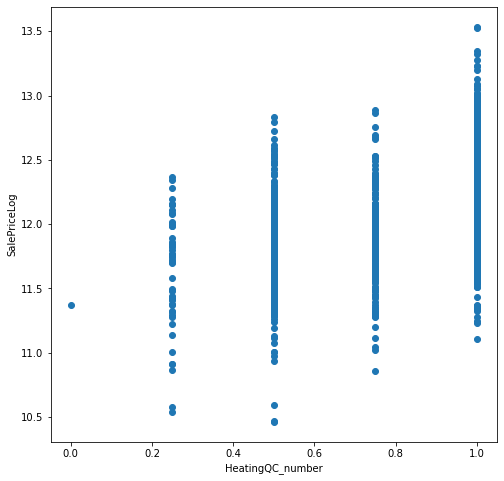

In [467]:
plt.figure(figsize= (8,8))
plt.scatter( train['HeatingQC_number'], train['SalePriceLog'])
plt.xlabel('HeatingQC_number')
plt.ylabel('SalePriceLog')
plt.show()

In [468]:
#let's make a model
reg = LinearRegression()
reg.fit(train[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number']],train['SalePriceLog'])

LinearRegression()

In [469]:
#let's print our regression coefficients
print(reg.coef_, reg.intercept_)

[0.21056743 0.7241209  0.48472586 0.95744183 0.3054991 ] 8.762928266155958


#### This way, we got our third linear regression model
$$ a(x, \textbf{w}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4 + w_5 x_5= 8.763 + 0.211x_1 + 0.724x_2 + 0.485x_3 + 0.957x_4 + 0.305x_5, where$$

$$x_1 is 'LotAreaLog'\\
x_2 is 'YearBuilt'\\
x_3 is 'OverallCond'\\
x_4 is 'GarageArea'\\
x_5 is 'HeatingQCnumber'$$

In [470]:
#now we will use our model to make prediction on test data
prediction = reg.predict(test[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number']])

In [471]:
#we need to save results of our prediction and submit it
sample_submission['SalePrice']=  np.exp( prediction)-1
sample_submission.to_csv('submission.csv', index = None)

In [472]:
#cross-validation time
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

kf = KFold (n_splits = 5)
kf.get_n_splits(train)

print(kf)

rmse_array = []

i= 0   
for i, (train_index, test_index) in enumerate(kf.split(train)):

    X_train, X_test = train.loc[train_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number']], train.loc[test_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    print("model.coef_: ",model.coef_ , model.intercept_)
    prediction = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=prediction , y_true=y_test))    
    rmse_array.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_array))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_array))))
mean_rmse_3 = np.mean(rmse_array)

KFold(n_splits=5, random_state=None, shuffle=False)
model.coef_:  [0.20710845 0.75394034 0.50237134 0.9400762  0.28836259] 8.7797689948171
0 0.21488362906919112
model.coef_:  [0.21221206 0.70728808 0.47200036 0.91891521 0.32128399] 8.765864735572098
1 0.24368473785456207
model.coef_:  [0.20541792 0.72716983 0.49898681 0.93690048 0.29043741] 8.818093740820515
2 0.24258342095907567
model.coef_:  [0.2129903  0.70204819 0.47675055 1.00668785 0.30694133] 8.748312715355102
3 0.23413544902459899
model.coef_:  [0.2150354  0.72820624 0.47085071 0.98817286 0.32128334] 8.704533180872609
4 0.2546886619053988
Mean rmse for 5-fold: 0.23799517976256532
std rmse for 5-fold: 0.01327506437976606


# For our third linear regression model we got next results:

### Kaggle score = 0.24272
### Mean on folds of cross-validation = 0.23800

# Fourth model

### I've decided to add such feature as 'BsmtCond' to the third model. Basement is the most important part of the house. If it's in a bad condition the risk that the house will go down is high.

#### Let's see if there is any correlation between 'BsmtCond' and 'SalePrice'.

According to data description we have the next range for BsmtCond:

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
       
Let's substitute it with numbers: NA=0, Po=1, Fa=2, TA=3, Gd=4, Ex=5.       

In [473]:
match={'Ex':5,'Gd':4,'TA':3,'Fa':2, 'Po':1, 'NA':0}
train['BsmtCond_number'] = np.nan
train['BsmtCond_number'] = train['BsmtCond'].map(match).fillna(train['BsmtCond_number'])
test['BsmtCond_number'] = np.nan
test['BsmtCond_number'] = test['BsmtCond'].map(match).fillna(test['BsmtCond_number'])

In [474]:
train['BsmtCond_number'] = (train['BsmtCond_number']).fillna(0)
test['BsmtCond_number'] = (test['BsmtCond_number']).fillna(0)

In [475]:
#I wold like to normalize Basement Condition data
_max = max(max(train['BsmtCond_number']), max(test['BsmtCond_number']))
_min = min(min(train['BsmtCond_number']), min(test['BsmtCond_number']))
train['BsmtCond_number'] = (train['BsmtCond_number'] - _min)/(_max - _min)
test['BsmtCond_number'] = (test['BsmtCond_number'] - _min)/(_max - _min)

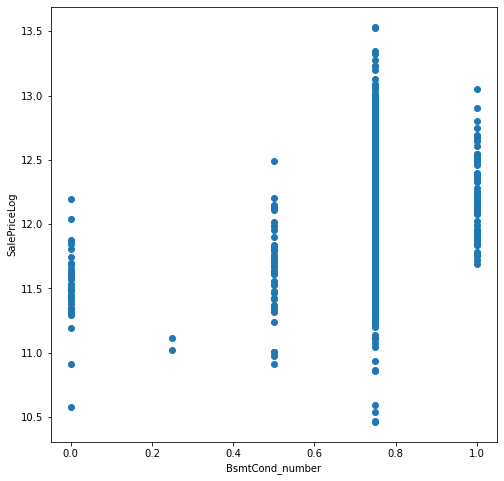

In [476]:
plt.figure(figsize= (8,8))
plt.scatter( train['BsmtCond_number'], train['SalePriceLog'])
plt.xlabel('BsmtCond_number')
plt.ylabel('SalePriceLog')
plt.show()

In [477]:
#let's make a model
reg = LinearRegression()
reg.fit(train[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number']],train['SalePriceLog'])

LinearRegression()

In [478]:
#let's print our regression coefficients
print(reg.coef_, reg.intercept_)

[0.21029972 0.68514633 0.42076601 0.94250086 0.2947836  0.29156768] 8.629224802097806


#### This way, we got our fourth linear regression model
$$ a(x, \textbf{w}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4 + w_5 x_5 + w_6 x_6= 8.629 + 0.210x_1 + 0.685x_2 + 0.421x_3 + 0.943x_4 + 0.295x_5 + 0.292x_6, where$$

$$x_1 is 'LotAreaLog'\\
x_2 is 'YearBuilt'\\
x_3 is 'OverallCond'\\
x_4 is 'GarageArea'\\
x_5 is 'HeatingQCnumber'\\
x_6 is 'BsmtCondnumber'$$

In [479]:
#now we will use our model to make prediction on test data
prediction = reg.predict(test[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number']])

In [480]:
#we need to save results of our prediction and submit it
sample_submission['SalePrice']=  np.exp( prediction)-1
sample_submission.to_csv('submission.csv', index = None)

In [481]:
#cross-validation time
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

kf = KFold (n_splits = 5)
kf.get_n_splits(train)

print(kf)

rmse_array = []

i= 0   
for i, (train_index, test_index) in enumerate(kf.split(train)):

    X_train, X_test = train.loc[train_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number']], train.loc[test_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    print("model.coef_: ",model.coef_ , model.intercept_)
    prediction = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=prediction , y_true=y_test))    
    rmse_array.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_array))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_array))))
mean_rmse_4 = np.mean(rmse_array)

KFold(n_splits=5, random_state=None, shuffle=False)
model.coef_:  [0.206529   0.71161473 0.43584668 0.92642684 0.27668772 0.28514588] 8.657860101109087
0 0.21088355101867165
model.coef_:  [0.21248342 0.67293646 0.41092579 0.9034136  0.31031042 0.28492163] 8.627246535382072
1 0.23970583177691446
model.coef_:  [0.20534108 0.69021878 0.43472023 0.91657937 0.27702673 0.31712579] 8.666735016497231
2 0.24243345679439418
model.coef_:  [0.21153045 0.66373915 0.41416978 0.9942333  0.29626389 0.28546499] 8.627603840073368
3 0.2296528822544082
model.coef_:  [0.21550655 0.68540316 0.40560747 0.97576678 0.31451128 0.28501251] 8.56876802251336
4 0.25185394272012357
Mean rmse for 5-fold: 0.2349059329129024
std rmse for 5-fold: 0.013939921480480512


# For our fourth linear regression model we got next results:

### Kaggle score = 0.23801
### Mean on folds of cross-validation = 0.23491

# Fifth model
### I've decided to add such feature as 'LandSlope' to the fourth model. I think it is quite hard to built smth on land with severe slope.

#### Let's see if there is any correlation between 'LandSlope' and 'SalePrice'.

According to data description we have the next range for LandSlope:

LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
       
Let's substitute it with numbers: Gtl = 3, Mod = 2, Sev = 1       

In [482]:
match={'Gtl':3,'Mod':2,'Sev':1}
train['LandSlope_number'] = np.nan
train['LandSlope_number'] = train['LandSlope'].map(match).fillna(train['LandSlope_number'])
test['LandSlope_number'] = np.nan
test['LandSlope_number'] = test['LandSlope'].map(match).fillna(test['LandSlope_number'])

In [483]:
#I wold like to normalize Land Slope data
_max = max(max(train['LandSlope_number']), max(test['LandSlope_number']))
_min = min(min(train['LandSlope_number']), min(test['LandSlope_number']))
train['LandSlope_number'] = (train['LandSlope_number'] - _min)/(_max - _min)
test['LandSlope_number'] = (test['LandSlope_number'] - _min)/(_max - _min)

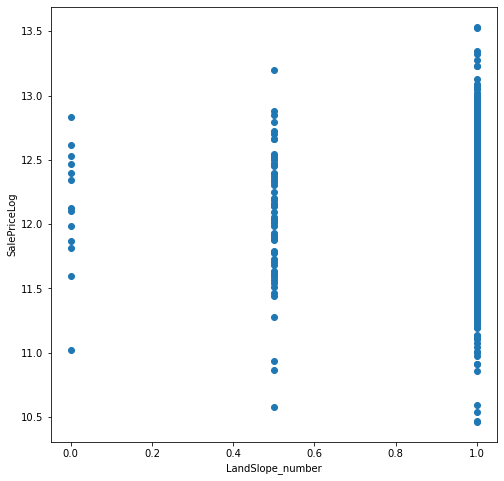

In [484]:
plt.figure(figsize= (8,8))
plt.scatter( train['LandSlope_number'], train['SalePriceLog'])
plt.xlabel('LandSlope_number')
plt.ylabel('SalePriceLog')
plt.show()

In [485]:
#let's make a model
reg = LinearRegression()
reg.fit(train[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number','LandSlope_number']],train['SalePriceLog'])

LinearRegression()

In [486]:
#let's print our regression coefficients
print(reg.coef_, reg.intercept_)

[ 0.2101144   0.68522854  0.42082309  0.94264098  0.29483914  0.29145074
 -0.00251413] 8.633254890091267


#### This way, we got our fifth linear regression model
$$ a(x, \textbf{w}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4 + w_5 x_5 + w_6 x_6 + w_7 x_7= 8.633 + 0.210x_1 + 0.685x_2 + 0.421x_3 + 0.943x_4 + 0.295x_5 + 0.291x_6 - 0.003x_7, where$$

$$x_1 is 'LotAreaLog'\\
x_2 is 'YearBuilt'\\
x_3 is 'OverallCond'\\
x_4 is 'GarageArea'\\
x_5 is 'HeatingQCnumber'\\
x_6 is 'BsmtCondnumber'\\
x_7 is 'LandSlopenumber'$$

In [487]:
#now we will use our model to make prediction on test data
prediction = reg.predict(test[['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number','LandSlope_number']])

In [488]:
#we need to save results of our prediction and submit it
sample_submission['SalePrice']=  np.exp( prediction)-1
sample_submission.to_csv('submission.csv', index = None)

In [489]:
#cross-validation time
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

kf = KFold (n_splits = 5)
kf.get_n_splits(train)

print(kf)

rmse_array = []

i= 0   
for i, (train_index, test_index) in enumerate(kf.split(train)):

    X_train, X_test = train.loc[train_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number','LandSlope_number']], train.loc[test_index, ['LotAreaLog','YearBuilt','OverallCond','GarageArea','HeatingQC_number','BsmtCond_number','LandSlope_number']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    print("model.coef_: ",model.coef_ , model.intercept_)
    prediction = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred=prediction , y_true=y_test))    
    rmse_array.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_array))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_array))))
mean_rmse_5 = np.mean(rmse_array)

KFold(n_splits=5, random_state=None, shuffle=False)
model.coef_:  [0.20788457 0.71093583 0.43495798 0.92558161 0.27604193 0.28611292
 0.01861599] 8.628578471500877
0 0.2110351898919516
model.coef_:  [ 0.21182047  0.67337485  0.41083682  0.90358203  0.31062835  0.28403345
 -0.01099553] 8.644025609963462
1 0.23974232188153133
model.coef_:  [ 0.20211845  0.69135709  0.43542551  0.91953358  0.2776286   0.3162374
 -0.04517291] 8.738011138068005
2 0.2430349580327904
model.coef_:  [0.21251245 0.66334305 0.41374051 0.99338354 0.29599518 0.28585825
 0.01150353] 8.60824313780265
3 0.22971303077913433
model.coef_:  [0.21591792 0.6852573  0.40550674 0.97534203 0.31446094 0.28526202
 0.00530725] 8.560032154289765
4 0.2518681287290734
Mean rmse for 5-fold: 0.23507872586289622
std rmse for 5-fold: 0.013955766639544388


# For our fourth linear regression model we got next results:

### Kaggle score = 0.23798
### Mean on folds of cross-validation = 0.23508

# Final results

In [445]:
#let's plot a graph with kaggle score and mean on folds of cross-validation
means=[mean_rmse_1,mean_rmse_2,mean_rmse_3,mean_rmse_4,mean_rmse_5]
kaggle=[0.28014,0.25269,0.24272,0.23801,0.23798]

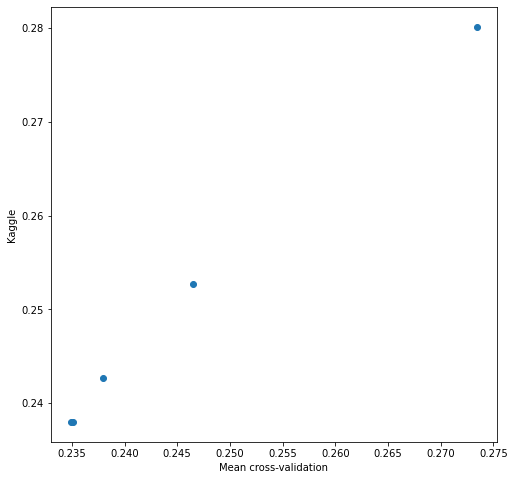

In [446]:
plt.figure(figsize= (8,8))
plt.scatter( [mean_rmse_1,mean_rmse_2,mean_rmse_3,mean_rmse_4,mean_rmse_5], kaggle)
plt.xlabel('Mean cross-validation')
plt.ylabel('Kaggle')
plt.show()